# Notes to myself & flags

In [ ]:
ssps_list = ['ssp1','ssp2','ssp3','ssp4','ssp5']


TODO
* LULC 2000 instead of 2015 please !
* Lat/Lon are rounded up :(

Big assumptions to flag
 * Assuming soil quality doesn't change (really bc no data on that)
 * - Is it not a terrible assumption to assume all 5min (10km) cropland pixel is cultivated? YES
  - Calculated %Cropland crop_mask
  - Else go back to Monfreda and find use %area cultivated for each cell, then mutliply this by yield
  - And calc F['%cultivated'] = ... (aggregate crops again...)
  - see where I export future_df

# Imports

In [1]:
import pickle

In [36]:
import os
from collections import OrderedDict

import hazelbean as hb
import numpy as np
import pandas as pd

In [2]:
import matplotlib
import matplotlib.pyplot as plt
import mpl_toolkits
from mpl_toolkits.basemap import Basemap
import seaborn as sns

In [7]:
import math
from scipy import stats

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import Ridge
from sklearn.feature_selection import RFE
from sklearn.preprocessing import PolynomialFeatures
import sklearn.metrics

import xgboost as xgb

In [3]:
import gdal
import pygeoprocessing
# import taskgraph
import netCDF4

In [4]:
## I can't install logging :'(
## Command "python setup.py egg_info" failed with error code 1 in /private/var/folders/zz/mdt_32ps1ydd2xls85z7qt240000gp/T/pip-install-gr4qw335/logging/

import logging as L
L.basicConfig(level=logging.DEBUG)
LOGGER = L.getLogger(__name__)

NameError: name 'logging' is not defined

# Pre-processing

## Caloric yields maps preparation

### Make relevant crop list

In [ ]:
## Merge BCK's CSVs
sustenance = pd.read_csv('../Data/inputs/Crop/crop_table_BCK.csv')
crop_caloric_contents = pd.read_csv('../Data/inputs/Crop/crop_nutrient.csv',sep=';')
crop_caloric_contents = crop_caloric_contents.merge(sustenance, how='left',
                                                    right_on='file_name',
                                                   left_on='filenm')
crop_caloric_contents.to_csv('../Data/inputs/Crop/crop_nutrient_contents.csv')

In [5]:
crop_caloric_contents = pd.read_csv('../Data/inputs/Crop/crop_nutrient_contents.csv')
crop_caloric_contents = crop_caloric_contents.set_index('filenm')

crops_list = []
for cropnm in crop_caloric_contents.index:
    if crop_caloric_contents['nutritional_relevance'][cropnm] == 1:
        crops_list.append(cropnm)

### Make Caloric Production rasters + Aggregate (all crops)

In [13]:
from raster_calc_utils import *
from spatial_utils import *

In [ ]:
caloric_production_path_list = []
crop_HarvestedAreaHectares_path_list = []

Crop_dir = '../Data/inputs/Crop'
Earthstat_dir = '../Data/inputs/Crop/Earthstat/HarvestedAreaYield175Crops_Geotiff'
ha_per_cell_5min_path = '../Data/inputs/Base/ha_per_cell_5m.tif'

Earthstat_intermediate_dir = '../Data/inputs/Crop/Earthstat_Preprocessed'


## Recalculate ha_per_cell at 5min
y_ha_column = None 

for cropnm in crops_list:
    crop_YieldPerHectare_path = os.path.join(Earthstat_dir,cropnm+'_HarvAreaYield_Geotiff/'+cropnm+'_YieldPerHectare.tif')
    crop_HarvestedAreaHectares_path = os.path.join(Earthstat_dir,cropnm+'_HarvAreaYield_Geotiff/'+cropnm+'_HarvestedAreaHectares.tif')
    crop_Production_path = os.path.join(Earthstat_dir,cropnm+'_HarvAreaYield_Geotiff/'+cropnm+'_Production.tif')
    
    crop_HarvestedAreaHectares_raster_info = pygeoprocessing.get_raster_info(
            crop_HarvestedAreaHectares_path)
    crop_HarvestedAreaHectares_nodata = crop_HarvestedAreaHectares_raster_info['nodata'][0]
    if crop_HarvestedAreaHectares_nodata == None:
        crop_HarvestedAreaHectares_nodata = 0
    crop_HarvestedAreaHectares_path_list.append(crop_HarvestedAreaHectares_path)
        
    crop_Production_raster_info = pygeoprocessing.get_raster_info(
            crop_Production_path)
    crop_Production_nodata = crop_Production_raster_info['nodata'][0]
    if crop_Production_nodata == None:
        crop_Production_nodata = 0
    
    if y_ha_column is None:
        y_lat_array = np.linspace(
                crop_HarvestedAreaHectares_raster_info['geotransform'][3],
                crop_HarvestedAreaHectares_raster_info['geotransform'][3] +
                crop_HarvestedAreaHectares_raster_info['geotransform'][5] *
                crop_HarvestedAreaHectares_raster_info['raster_size'][1],
                crop_HarvestedAreaHectares_raster_info['raster_size'][1])
        y_ha_array = area_of_pixel(
                abs(crop_HarvestedAreaHectares_raster_info['geotransform'][1]),
                y_lat_array) / 10000.0
        y_ha_column = y_ha_array.reshape((y_ha_array.size, 1))

    ## Skip this because I have Prods rasters - was just to compare !
    ## 1) Make raster Crop Production Yield from Earthstats rasters:
    ## Crop_Production [tons] = Crop_YieldPerHectare[tons/ha] * ha_per_cell_5min * Crop_HarvestedAreaFraction
    ## But not needed - I have Prods rasters- was just to compare !
    
    '''
    !!!! HAVENT RUN SUCCESSFULLY. DOESN'T RETURN ACTUAL ERROR ONLY TASKGRAPH ERROR

    crop_production_path = os.path.join(
        Earthstat_intermediate_dir,'Productions','%s_Production.tif' % cropnm)
    
    crop_production_nodata = -1.0
    crop_production_task = task_graph.add_task(
            func=pygeoprocessing.raster_calculator,
            args=(
                #base_raster_path_band_const_list =
                    [(crop_YieldPerHectare_path, 1),
                     (crop_HarvestedAreaHectares_path, 1),
                     y_ha_column,
                     (crop_HarvestedAreaHectares_nodata, 'raw'),
                     (crop_production_nodata, 'raw')],
                crop_production_op,     #local_op
                crop_production_path,   #target_raster_path
                gdal.GDT_Float32,       #datatype_target 
                crop_production_nodata  #nodata_target
                ),
            target_path_list=[crop_production_path],
            task_name=('Calc Crop Production Raster for '+ cropnm))
    '''  

    ## 2) Convert to Caloric Production with crop_nutrient_contents table:
    ## Crop_Caloric_Production [cal] = Crop_Production [tons] * Crop_Energy[kJ/100g from crop_nutrient table] * 1e4[100g/tons] * 239,006[cal/kJ]
    #print('Making '+cropnm+' Caloric Production raster')
        
        
    caloric_production_path = os.path.join(
        Earthstat_intermediate_dir,'Productions','%s_Caloric_Production.tif' % cropnm) 
    caloric_production_path_list.append(caloric_production_path)
    
    crop_energy = crop_caloric_contents['Energy'][cropnm] * 2390060
    
    crop_prod_array = (crop_Production_path,1)
    cal_per_ton = (crop_energy,'raw')
    nodata = (crop_Production_nodata, 'raw')
    
    pygeoprocessing.raster_calculator(
        base_raster_path_band_const_list = [crop_prod_array,cal_per_ton,nodata],
        local_op = convert_production_tons_to_caloric,
        target_raster_path = caloric_production_path,
        datatype_target = gdal.GDT_Float32,
        nodata_target = crop_Production_nodata)
 

In [42]:
crop_HarvestedAreaHectares_path_list

NameError: name 'crop_HarvestedAreaHectares_path_list' is not defined

In [44]:
# Aggregation

# Total caloric production (sum caloric_Productions)
#print('Adding '+cropnm+' Total caloric production')

Total_Caloric_Production_path = os.path.join(
    Earthstat_intermediate_dir, 'Total_caloric_production.tif')

pygeoprocessing.raster_calculator(
    base_raster_path_band_const_list =
        [(crop_Production_nodata, 'raw')] +
        [(path, 1) for path in caloric_production_path_list],
    local_op = sum_arrays_op,
    target_raster_path = Total_Caloric_Production_path,
    datatype_target = gdal.GDT_Float32,
    nodata_target = crop_Production_nodata)

# Total harvested areas (ha) (by summing harvested hectares)
#print('Adding '+cropnm+' to Total harvested areas')

Total_harvested_area_ha_raster_path = os.path.join(
    Earthstat_intermediate_dir, 'Total_harvested_area_ha.tif')

pygeoprocessing.raster_calculator(
    base_raster_path_band_const_list =
        [(crop_HarvestedAreaHectares_nodata, 'raw')] +
        [(path, 1) for path in crop_HarvestedAreaHectares_path_list],
    local_op = sum_arrays_op,
    target_raster_path = Total_harvested_area_ha_raster_path,
    datatype_target = gdal.GDT_Float32,
    nodata_target = crop_HarvestedAreaHectares_nodata)

# Aggregated caloric yield = [total caloric production/Total harvested areas(ha)]
#print('Making aggregated caloric yield raster')

agg_calories_yield_raster_path = os.path.join(
    Earthstat_intermediate_dir, 'agg_Caloric_yield_per_ha.tif')

pygeoprocessing.raster_calculator(
    base_raster_path_band_const_list =
        [(Total_Caloric_Production_path, 1),
         (Total_harvested_area_ha_raster_path, 1),
         (crop_HarvestedAreaHectares_nodata, 'raw')],
    local_op = div_arrays_op,
    target_raster_path = agg_calories_yield_raster_path,
    datatype_target = gdal.GDT_Float32,
    nodata_target = crop_Production_nodata)

In [32]:
# Aggregated caloric yield = [total caloric production/Total harvested areas(ha)]
#print('Making aggregated caloric yield raster')

agg_calories_yield_raster_path = os.path.join(
    Earthstat_intermediate_dir, 'agg_Caloric_yield_per_ha.tif')

pygeoprocessing.raster_calculator(
    base_raster_path_band_const_list =
        [(Total_Caloric_Production_path, 1),
         (Total_harvested_area_ha_raster_path, 1),
         (crop_HarvestedAreaHectares_nodata, 'raw')],
    local_op = div_arrays_op,
    target_raster_path = agg_calories_yield_raster_path,
    datatype_target = gdal.GDT_Float32,
    nodata_target = crop_Production_nodata)

### TO FIX : Utils that I actually can't export because numpy doesn't work in utils.py?!

In [19]:
def convert_production_tons_to_caloric(crop_prod_array, calories_per_ton, nodata):
    """Calorie (i) production = Crop (i) production x KJ content of crop (i).

    Parameters:
        crop_prod_array (array): production in tons.
        calories_per_ton (float): calories/ton accounting for % refuse
            of the crop.
        nodata (float): nodata value for `crop_prod_array` and result.

    Returns:
        calorie production production * calories / ton

    """
    result = np.array(crop_prod_array)
    result[~np.isclose(crop_prod_array, nodata)] *= calories_per_ton
    return result

def div_arrays_op(numerator_array, denominator_array, nodata):
    """Calculate calorie yield.

    Parameters:
        numerator
        e.g total_calorie_array (np.ndarray): total calories per element
        denominator
        e.g harvested_area_ha_array (np.ndarray): amount of total harvested
            area in hectares per eleent.
        nodata (float): the nodata value for all inputs and result.

    Returns:
        divided
        e.g calorie yield = total calorie production / sum(harvested area)

    """
    result = np.empty_like(numerator_array)
    result[:] = nodata
    zero_mask = (denominator_array == 0.0)
    valid_mask = (
        ~np.isclose(numerator_array, nodata) &
        ~np.isclose(denominator_array, nodata)) & ~zero_mask
    result[valid_mask] = (
        numerator_array[valid_mask] / (
            denominator_array[valid_mask]))
    result[zero_mask] = 0.0
    return result




def crop_production_op(
        yield_array, prop_harvest_area, cell_area_ha,
        prop_harvest_area_nodata, target_nodata):
    """Calculate crop production

    Parameters:
        yield_array (np.ndarray): yield of crop in Tons/Ha
        prop_harevest_area (np.ndarray): proportional harvested area of
            the crop per cell.
        cell_harea_ha (np.ndarray): area of the cell in Ha.
        prop_harvest_area_nodata (float): nodata value for prop_harevest_area
        target_nodata (float): nodata value for result

    Returns:
        Crop production =
            Yield(i) x harvested area (proportion) (i) * area of cell.

    """
    crop_production = np.empty_like(yield_array, dtype=np.float32)
    crop_production[:] = target_nodata
    valid_mask = ~np.isclose(prop_harvest_area, prop_harvest_area_nodata)
    crop_production[valid_mask] = (
        yield_array[valid_mask] * prop_harvest_area[valid_mask] *
        cell_area_ha[valid_mask])
    return crop_production

def mult_arrays_op(nodata, *array_list):
    """Multiply array stack and ignore nodata."""
    result = np.ones(array_list[0].shape, dtype=np.float32)
    valid_mask = np.empty(result.shape, dtype=np.bool)
    valid_mask[:] = False
    for array in array_list:
        local_valid_mask = ~np.isclose(array, nodata)
        valid_mask |= local_valid_mask
    for array in array_list:
        result[valid_mask] *= array[valid_mask]
    result[~valid_mask] = nodata
    return result


def sum_arrays_op(nodata, *array_list):
    """Sum all rasters assuming they all have the same nodata value."""
    result = np.zeros(array_list[0].shape, dtype=np.float32)
    valid_mask = np.empty(result.shape, dtype=np.bool)
    valid_mask[:] = False
    for array in array_list:
        local_valid_mask = ~np.isclose(array, nodata)
        valid_mask |= local_valid_mask
        result[local_valid_mask] += array[local_valid_mask]
    result[~valid_mask] = nodata
    return result

def calories_yield_op(total_calorie_array, harvested_area_ha_array, nodata):
    """Calculate calorie yield.

    Parameters:
        total_calorie_array (np.ndarray): total calories per element
        harvested_area_ha_array (np.ndarray): amount of total harvested
            area in hectares per eleent.
        nodata (float): the nodata value for all inputs and result.

    Returns:
        calorie yield = total calorie production / sum(harvested area)

    """
    result = np.empty_like(total_calorie_array)
    result[:] = nodata
    zero_mask = (harvested_area_ha_array == 0.0)
    valid_mask = (
        ~np.isclose(total_calorie_array, nodata) &
        ~np.isclose(harvested_area_ha_array, nodata)) & ~zero_mask
    result[valid_mask] = (
        total_calorie_array[valid_mask] / (
            harvested_area_ha_array[valid_mask]))
    result[zero_mask] = 0.0
    return result

def area_of_pixel(pixel_size, center_lat):
    """Calculate m^2 area of a wgs84 square pixel.

    Adapted from: https://gis.stackexchange.com/a/127327/2397

    Parameters:
        pixel_size (float): length of side of pixel in degrees.
        center_lat (float): latitude of the center of the pixel. Note this
            value +/- half the `pixel-size` must not exceed 90/-90 degrees
            latitude or an invalid area will be calculated.

    Returns:
        Area of square pixel of side length `pixel_size` centered at
        `center_lat` in m^2.

    """
    a = 6378137  # meters
    b = 6356752.3142  # meters
    e = np.sqrt(1-(b/a)**2)
    area_list = []
    for f in [center_lat+pixel_size/2, center_lat-pixel_size/2]:
        zm = 1 - e*np.sin(np.radians(f))
        zp = 1 + e*np.sin(np.radians(f))
        area_list.append(
            np.pi * b**2 * (
                np.log(zp/zm) / (2*e) +
                np.sin(np.radians(f)) / (zp*zm)))
    return pixel_size / 360. * (area_list[0]-area_list[1])

### Aggregate by crop types (To do)

In [39]:
# Total harvested areas (ha) per crop_type

for crop_type in crop_types_list:
    
    Total_harvested_area_ha_raster_path = os.path.join(
            Earthstat_intermediate_dir, crop_type+'_harvested_area_ha.tif')
        
    for cropnm in crops_list:
        crop_HarvestedAreaHectares_path = os.path.join(Earthstat_dir,cropnm+'_HarvAreaYield_Geotiff/'+cropnm+'_HarvestedAreaHectares.tif')
        crop_HarvestedAreaHectares_raster_info = pygeoprocessing.get_raster_info(
                crop_HarvestedAreaHectares_path)
        crop_HarvestedAreaHectares_nodata = crop_HarvestedAreaHectares_raster_info['nodata'][0]
        if crop_HarvestedAreaHectares_nodata == None:
            crop_HarvestedAreaHectares_nodata = 0

        if cropnm in crop_membership[crop_type]:

            pygeoprocessing.raster_calculator(
            base_raster_path_band_const_list =
                [(crop_HarvestedAreaHectares_nodata, 'raw'),
                 (crop_HarvestedAreaHectares_path, 1)],
            local_op = sum_arrays_op,
            target_raster_path = Total_harvested_area_ha_raster_path,
            datatype_target = gdal.GDT_Float32,
            nodata_target = crop_HarvestedAreaHectares_nodata)

#### Crop types list

In [37]:
crop_types_list = ['c3ann','c3per','c4ann','c4per','c3nfx'] # = crop_membership.keys()

crop_membership = OrderedDict()
crop_membership['c3ann'] = [
        'aniseetc',
        'artichoke',
        'asparagus',
        'bambara',
        'barley',
        'buckwheat',
        'cabbage',
        'canaryseed',
        'carob',
        'carrot',
        'cassava',
        'cauliflower',
        'cerealnes',
        'chestnut',
        'cinnamon',
        'cucumberetc',
        'currant',
        'date',
        'eggplant',
        'fonio',
        'garlic',
        'ginger',
        'mixedgrain',
        'hazelnut',
        'hempseed',
        'hop',
        'kapokseed',
        'linseed',
        'mango',
        'mate',
        'mustard',
        'nutmeg',
        'okra',
        'onion',
        'greenonion',
        'peppermint',
        'potato',
        'pumpkinetc',
        'pyrethrum',
        'ramie',
        'rapeseed',
        'rice',
        'safflower',
        'sisal',
        'sorghumfor',
        'sourcherry',
        'spinach',
        'sugarbeet',
        'sunflower',
        'taro',
        'tobacco',
        'tomato',
        'triticale',
        'tung',
        'vanilla',
        'vetch',
        'walnut',
        'watermelon',
        'wheat',
        'yam',
        'yautia']

crop_membership['c3per'] = [
        'almond',
        'apple',
        'apricot',
        'areca',
        'avocado',
        'banana',
        'blueberry',
        'brazil',
        'cashewapple',
        'cashew',
        'cherry',
        'chicory',
        'chilleetc',
        'citrusnes',
        'clove',
        'cocoa',
        'coconut',
        'coffee',
        'cotton',
        'cranberry',
        'fig',
        'flax',
        'grapefruitetc',
        'grape',
        'jute',
        'karite',
        'kiwi',
        'kolanut',
        'lemonlime',
        'lettuce',
        'abaca',
        'melonetc',
        'melonseed',
        'oats',
        'oilpalm',
        'oilseedfor',
        'olive',
        'orange',
        'papaya',
        'peachetc',
        'pear',
        'pepper',
        'persimmon',
        'pineapple',
        'pistachio',
        'plantain',
        'plum',
        'poppy',
        'quince',
        'quinoa',
        'rasberry',
        'rubber',
        'rye',
        'stonefruitnes',
        'strawberry',
        'stringbean',
        'sweetpotato',
        'tangetc',
        'tea',
    ]

crop_membership['c4ann'] = [
        'maize',
        'millet',
        'sorghum',
    ]

crop_membership['c4per'] = [
        'greencorn',
        'sugarcane',

    ]

crop_membership['c3nfx'] = [
        'bean',
        'greenbean',
        'soybean',
        'chickpea',
        'clover',
        'cowpea',
        'groundnut',
        'lupin',
        'pea',
        'greenpea',
        'pigeonpea',
        'lentil',
        'legumenes',
        'broadbean',
        'castor',

    ]

## Fertilizers: NetCDF to GeoTiffs

Nitrogen	Fertilizer:	(units	kg	N/ha/crop	season;	(per	year	for	single	cropping))
* fertl_c3ann: N. fertilizer rate for C3 annual crops
* fertl_c4ann: N. fertilizer rate for C4 annual crops
* fertl_c3per: N. fertilizer rate for C3 perennial crops
* fertl_c4per: N. fertilizer rate for C4 perennial crops
* fertl_c3nfx: N. fertilizer rate for C3 N-fixing crops

In management_ssp.nc data:
* Year = Band number + 2014 (2015: t=0, band=1) --> 2050 is band 36


In management_historical.nc data:
* Year = Band number + 849 (850: t=0, band=1) --> 2000 is band 1151


### Utils

In [1]:
ssps_list = ['ssp1','ssp2','ssp3','ssp4','ssp5']

In [3]:
def netcdf_to_geotiff(base_raster_path,target_raster_path,
                      band_num=1):
    '''
    base_raster_path should be in format : r'NETCDF:"path:dimension_name' 
    '''
    
    gtiff_driver = gdal.GetDriverByName('GTiff')

    raster = gdal.OpenEx(base_raster_path, gdal.OF_RASTER)

    target_raster = gtiff_driver.CreateCopy(target_raster_path, raster)
    target_band = target_raster.GetRasterBand(band_num)
    target_band.XSize
    target_band.FlushCache()
    target_array = target_band.ReadAsArray()

    target_band = None
    target_raster = None

### NetCDF to Geotiffs

In [ ]:
# SSPs data 

for crop_type_raster in ['fertl_c3ann','fertl_c3per','fertl_c3nfx',
               'fertl_c4ann','fertl_c4per']:
    
    for ssp in ssps_list:
        base_raster_path = r'NETCDF:"../Data/inputs/Management/Fertilizers/management_'+ssp+'.nc":'+crop_type_raster
        target_raster_path = '../Data/inputs/Management/Fertilizers/'+ssp+'/'+crop_type_raster+'.tif'
        netcdf_to_geotiff(base_raster_path,target_raster_path,
                      band_num=36) # Band number = 36 for year 2050

In [ ]:
# 2000 data

for crop_type_raster in ['fertl_c3ann','fertl_c3per','fertl_c3nfx',
               'fertl_c4ann','fertl_c4per']:
    
    base_raster_path = r'NETCDF:"../Data/inputs/Management/Fertilizers/management_historical.nc":'+crop_type_raster
    target_raster_path = '../Data/inputs/Management/Fertilizers/2000/'+crop_type_raster+'.tif'

    netcdf_to_geotiff(base_raster_path,target_raster_path,
                      band_num=1151) # Band number = 1151 for year 2000

Actually the cell above maybe manually because took forever to run !!

### Aggregate fertilizers 

In [40]:
crop_types_list

['c3ann', 'c3per', 'c4ann', 'c4per', 'c3nfx']

Croptype_harvestedarea should already account for number of seasons. You'll see some grid cells for some crops are > 1. That's because the area is already multiplied by the number of seasons


LUH Inputs:
for crop type in ['c3ann', 'c3per', 'c4ann', 'c4per', 'c3nfx']: 
Croptype_applicationrate [kg N/ha/crop season] for crop type in ['c3ann', 'c3per', 'c4ann', 'c4per', 'c3nfx']

To aggregate:
* Total application of fertilizers annually = 
Sum for each crop type:
Croptype_applicationrate * Croptype_HarvestedArea 
*  Aggregated application rate [kg N/ha] =
Total application of fertilizers annually / Total_HarvestedArea


In [ ]:
for crop_type in crop_types_list:
    croptype_harvested_area_ha_raster_path = os.path.join(
            Earthstat_intermediate_dir, crop_type+'_harvested_area_ha.tif')

In [68]:
dataset.dimensions

OrderedDict()

In [70]:
output_dir = '../Data/inputs/Management/Fertilizers/test7'
extract_luh_netcdf_to_geotiffs(input_test, output_dir, 50)

In [60]:
output_dir = '../Data/inputs/Management/Fertilizers/test2'
extract_luh_netcdf_to_geotiffs(input_test, output_dir, 2)

In [57]:
extract_luh_netcdf_to_geotiffs(input_test, output_dir, 1)

In [59]:
extract_luh_netcdf_to_geotiffs(input_test, output_dir, 0)

In [40]:
def extract_luh_netcdf_to_geotiffs(input_nc_uri, output_dir, dim_selection_indices):
    """
    WARNING: currently only works given the nc structure of LUH2

    dim_selection_indices allows you to select all the data specific to an asigned set of indices.
    For example, with a standard time, lat, lon dimension structure of the .nc, assigning
    dim_selection_indices = [7, None, None] would grab time=7, all lats, all lons. If dim_selection_indices
    is a single value, it assumes that will be the selection for the first dimension..
    """

    if type(dim_selection_indices) in [float, int]:
        dim_selection_indices = [dim_selection_indices, None, None]

    L.info('Called extract_luh_netcdf_to_geotiffs on ' + str(input_nc_uri))
    ncfile = netCDF4.Dataset(input_nc_uri, 'r')
    dim_names = ncfile.dimensions.keys()
    dims_data = OrderedDict()
    dim_lengths = []
    for dim_name in dim_names:
        if dim_name != 'bounds':
            dims_data[dim_name] = ncfile.variables[dim_name][:]
            dim_lengths.append(len(dims_data[dim_name]))

    # ASSUME THIS IS GLOBAL to derive the geotransform
    res = (360.0) / len(dims_data['lon'])
    geotransform = [-180.0, res, 0.0, 90.0, 0.0, -1 * res]
    projection = 'wgs84'

    for var_name, var in ncfile.variables.items():
        if 'standard_name' in var.__dict__:
            var_string = str(var_name)
            # var_string = str(var_name) + ' ^ ' + var.__dict__['standard_name'] + ' ^ ' + var.__dict__['long_name']

            L.info('Processing ' + var_string)

            if var_name not in dim_names:
                # BROKEN, this wouldn't work with other dim_selection_indices schemes.
                array = var[:][dim_selection_indices[0]]

                no_data_value = -9999
                array = np.where(array > 1E19, no_data_value, array)

                output_geotiff_uri = os.path.join(output_dir, var_string + '.tif')
                #hb.
                save_array_as_geotiff(array, output_geotiff_uri, ndv=no_data_value, data_type=7,
                                      match_data_type=7,
                                      compress=True,geotransform_override=geotransform, projection_override=projection)

                # output_geotiff_rp_uri = hb.suri(output_geotiff_uri, 'eck')
                # wkt = hb.get_wkt_from_epsg_code(54012)
                # hb.reproject_dataset_uri(output_geotiff_uri, 0.25, wkt, 'bilinear', output_geotiff_rp_uri)


In [47]:
def save_array_as_geotiff(array, out_uri, geotiff_uri_to_match=None, ds_to_match=None, band_to_match=None,
                          match_data_type=None,match_ndv=-99999,#Added Cha
                          optimize_data_type=True, data_type=None, ndv=None, data_type_override=None, no_data_value_override=None,
                          geotransform_override=None, projection_override=None, n_cols_override=None,
                          n_rows_override=None, compress=False, compression_method=None,
                          verbose=None, set_inf_to_no_data_value=False,
                          save_png=False):
    '''
    Saves an array as a geotiff at uri_out. Attempts to correctly deal with many possible data flaws, such as
    assigning a datatype to the geotiff that matches the required pixel depth. Also determines the best (according to me)
    no_data_value to use based on the dtype and range of the data
    '''
    execute_in_python = True

    n_cols = array.shape[1]
    n_rows = array.shape[0]
    geotransform = None
    projection = None
    data_type = None
    ndv = None

    if geotiff_uri_to_match != None:
        ds_to_match = gdal.Open(geotiff_uri_to_match)
        band_to_match = ds_to_match.GetRasterBand(1)

    # ideally, the function is passed a gdal dataset (ds) and the gdal band.
    if ds_to_match and band_to_match:
        n_cols = ds_to_match.RasterXSize
        n_rows = ds_to_match.RasterYSize
        match_data_type = band_to_match.DataType
        match_ndv = band_to_match.GetNoDataValue()
        geotransform = ds_to_match.GetGeoTransform()
        projection = ds_to_match.GetProjection()

    if data_type is None:
        if match_data_type is not None:
            data_type = match_data_type
        else:
            raise NameError('data_type not given and match_data_type not understood.')
    else:
        raise NameError('data_type not processed correctly.')


    if ndv is None:
        if match_ndv is not None:
            ndv = match_ndv
        else:
            raise NameError('ndv not given and match_data_type not understood.')
    else:
        raise NameError('ndv not processed correctly.')
    array = array.astype(hb.gdal_number_to_numpy_type[data_type])

    if geotransform_override:
        if type(geotransform_override) is str:
            geotransform = hb.config.common_geotransforms[geotransform_override]
        else:
            geotransform = geotransform_override

    if not geotransform:
        raise NameError('You must have a geotransform set, either in the geotiff_to_match, or manually as a 6-long list. '
                        'e.g. geotransform = (-180.0, 0.08333333333333333, 0.0, 90.0, 0.0, -0.08333333333333333) to '
                        'set to global extent with 5min cells or via a common keyword (defined in config).')

    if geotransform_override:
        if type(geotransform_override) is str:
            geotransform = hb.config.common_geotransforms[geotransform_override]
        else:
            geotransform = geotransform_override

    if projection_override:
        if type(projection_override) is str:
            if projection_override in hb.common_epsg_codes_by_name:
                projection_override = hb.common_epsg_codes_by_name[projection_override]
                srs = osr.SpatialReference()
                srs.ImportFromEPSG(int(projection_override))
                projection = srs.ExportToWkt()
            else:
                projection = projection_override # assume then it alreaydy was a wkt

        else:
            srs = osr.SpatialReference()
            srs.ImportFromEPSG(int(projection_override))
            projection = srs.ExportToWkt()

    if n_cols_override:
        n_cols = n_cols_override
    if n_rows_override:
        n_rows = n_rows_override

    if not projection:
        raise NameError('You must have a projection set, either in the geotiff_to_match, or manually via projection_override')

    # Process out_uri
    folder_uri, filename = os.path.split(out_uri)
    basename, file_extension = os.path.splitext(filename)
    if file_extension != '.tif':
        file_extension = '.tif'
        # L.info('No file_extension specified. Assuming .tif.')
    if os.path.exists(folder_uri) or not folder_uri:
        'Everything is fine.'
    elif geotiff_uri_to_match:
        print ('Folder did not exist, assuming you want the same as the geotiff_uri_to_match.')
        folder_uri = os.path.split(geotiff_uri_to_match)[0]
        if not os.path.exists(folder_uri):
            raise NameError('Folder in geotiff_uri_to_match did not exist.')
    else:
        try:
            os.mkdir(folder_uri)
        except:
            raise NameError('Not able to create required folder for ' + folder_uri)

    processed_out_uri = os.path.join(folder_uri, basename + file_extension)

    dst_options = ['BIGTIFF=IF_SAFER', 'TILED=YES']

    if compress and not compression_method:
        dst_options.append('COMPRESS=lzw')
        dst_options.append('PREDICTOR=2')

    if compression_method:
        dst_options.append('COMPRESS=' + compression_method)
        if compression_method == 'lzw':
            dst_options.append('PREDICTOR=2')

            # OUTDATED BUT HILARIOUS NOTE: When I compress an image with gdalwarp the result is often many times larger than the original!
            # By default gdalwarp operates on chunks that are not necessarily aligned with the boundaries of the blocks/tiles/strips of the output format, so this might cause repeated compression/decompression of partial blocks, leading to lost space in the output format.
            # Another possibility is to use gdalwarp without compression and then follow up with gdal_translate with compression:




    if set_inf_to_no_data_value:
        array[(array==np.inf) | (np.isneginf(array))] = ndv

    if execute_in_python:
        driver = gdal.GetDriverByName('GTiff')
        dst_ds = driver.Create(processed_out_uri, n_cols, n_rows, 1, data_type, dst_options)
        dst_ds.SetGeoTransform(geotransform)
        dst_ds.SetProjection(projection)
        dst_ds.GetRasterBand(1).SetNoDataValue(ndv)
        dst_ds.GetRasterBand(1).WriteArray(array)
    # else:
    #     command_line_gdal_translate(array, processed_out_uri, tiled=True, compression_method=compression_method)


    if not os.path.exists(processed_out_uri):
        raise NameError('Failed to create geotiff ' + processed_out_uri + '.')

    if verbose:
        print ('nyi 1293939202')
        # print ('Saved ' + processed_out_uri + ' which had stats: ' + desc(array))

    if save_png:
        if not ge:
            raise NameError('No plotting interface configured.')
        ge.show_array(array, output_uri=processed_out_uri.replace('.tif', '.png'), cbar_percentiles=[0,50,100])

In [1]:
import os
import pandas as pd
from osgeo import gdal, osr, gdal_array
import numpy as np

def nc4_to_tiff(in_filename,out_filename,EPSG=4326):
    #Open existing dataset
    src_ds = gdal.Open(in_filename)

    #Open output format driver, see gdal_translate --formats for list
    format = "GTiff"
    driver = gdal.GetDriverByName(format)

    #Output to new format
    dst_ds = driver.CreateCopy(out_filename, src_ds, -99)

    #Set projection
    srs = osr.SpatialReference()
    srs.ImportFromEPSG(EPSG)
    dst_ds.SetProjection(srs.ExportToWkt())

    #Properly close the datasets to flush to disk
    dst_ds = None
    src_ds = None


In [ ]:
#Set projection
srs = osr.SpatialReference()
srs.ImportFromEPSG(EPSG)
dst_ds.SetProjection(srs.ExportToWkt())


In [24]:
gdal.Open('NETCDF:"'+inpute+'":fertl_c3ann')

<osgeo.gdal.Dataset; proxy of <Swig Object of type 'GDALDatasetShadow *' at 0x125446060> >

In [25]:
gdal.Open('NETCDF:"'+inpute+'":time')

In [26]:
gdal.Open('NETCDF:"'+inpute+'":time')

format = "GTiff"
driver = gdal.GetDriverByName(format)

#Output to new format
dst_ds = driver.CreateCopy(outt, src_ds, -99)


In [19]:
from netCDF4 import Dataset
dataset = Dataset(inpute)

In [20]:
dataset

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4_CLASSIC data model, file format HDF5):
    host: UMD College Park
    comment: LUH2
    contact: gchurtt@umd.edu, lchini@umd.edu, steve.frolking@unh.edu, ritvik@umd.edu
    creation_date: 2017-08-30T10:12:47Z
    title: Land-Use Harmonization Data Sets
    activity_id: input4MIPs
    Conventions: CF-1.6
    data_structure: grid
    further_info_url: http://luh.umd.edu
    frequency: yr
    institution_id: UofMD
    realm: land
    references: Hurtt, Chini et al. 2011
    license: Land-Use Harmonization data produced by the University of Maryland is licensed under a Creative Commons Attribution "Share Alike" 4.0 International License (http://creativecommons.org/licenses/by/4.0/). The data producers and data providers make no warranty, either express or implied, including but not limited to, warranties of merchantability and fitness for a particular purpose. All liabilities arising from the supply of the information (including any li

In [17]:
! gdal_translate -of GTiff  ../Data/inputs/Management/Fertilizers/multiple-management_input4MIPs_landState_ScenarioMIP_UofMD-AIM-ssp370-2-1-f_gn_2015-2100.nc ../Data/inputs/Management/Fertilizers/testonsdonc.tif

Input file contains subdatasets. Please, select one of them for reading.


In [21]:
gdal.Open('NETCDF:"'+inpute+'":fertl_c3ann')

<osgeo.gdal.Dataset; proxy of <Swig Object of type 'GDALDatasetShadow *' at 0x124c8de10> >

In [15]:
format = "GTiff"
driver = gdal.GetDriverByName(format)
dst_ds = driver.CreateCopy(outt, src_ds, -99)

In [16]:
type(dst_ds)

NoneType

In [4]:
src_ds = gdal.Open(inpute)

In [2]:
inpute = '../Data/inputs/Management/Fertilizers/multiple-management_input4MIPs_landState_ScenarioMIP_UofMD-AIM-ssp370-2-1-f_gn_2015-2100.nc'
outt = '../Data/inputs/Management/Fertilizers/testonsdonc.tif'
nc4_to_tiff(inpute, outt)

AttributeError: 'NoneType' object has no attribute 'SetProjection'

# Resample to 5min

In [5]:
match_raster = '../Data/inputs/Base/country_ids.tif'

## Resample to %Cropland

In [343]:
def make_cropland_mask(input_raster, output_raster):
    file = gdal.Open(input_raster)
    band = file.GetRasterBand(1)
    band.SetNoDataValue(-999) #tentative
    raster = band.ReadAsArray()

    # Reclassification
    raster[raster != 2] = 0
    raster[raster == 2 ] = 1

    # Create new file
    file2 = gdal.GetDriverByName('GTiff').Create(output_raster, file.RasterXSize , file.RasterYSize , 1)
    file2.GetRasterBand(1).WriteArray(raster)
    file2.GetRasterBand(1).SetNoDataValue(-999) #tentative
    file2.SetProjection(file.GetProjection())
    file2.SetGeoTransform(file.GetGeoTransform())
    file2.FlushCache()

In [14]:
## Resample LUs to Cropland masks

for filename in os.listdir('../Data/inputs/LU/SEALS_Oct18(300m)'):
    if filename.endswith(".tif"):  
        input_raster = os.path.join('../Data/inputs/LU/SEALS_Oct18(300m)', filename)
        intermediate_raster = ('../Data/inputs/LU/SEALS_Oct18_CropMask_300m/Cropmask_'+filename)
        output_raster = ('../Data/inputs/LU/SEALS_Oct18_CropMask_5m/Cropmask_'+filename)
        
        #print('Making Cropland Mask for '+filename)
        #make_cropland_mask(input_raster, intermediate_raster)
        
        print('Resampling Cropland Mask of '+filename+' to 5 arcmin')
        hb.spatial_utils.align_dataset_to_match(intermediate_raster,
                                        match_raster,
                                        output_raster,
                                        resample_method='average',
                                        output_data_type=7)

Resampling Cropland Mask of lulc_RCP6.0_SSP4.tif to 5 arcmin
ReprojectImage for resize_and_resample_dataset_uri 6.000096450617284 percent complete
ReprojectImage for resize_and_resample_dataset_uri 11.000257201646091 percent complete
ReprojectImage for resize_and_resample_dataset_uri 17.00070730452675 percent complete
ReprojectImage for resize_and_resample_dataset_uri 23.00034293552812 percent complete
ReprojectImage for resize_and_resample_dataset_uri 29.000192901234566 percent complete
ReprojectImage for resize_and_resample_dataset_uri 35.00042866941015 percent complete
ReprojectImage for resize_and_resample_dataset_uri 41.00039651920439 percent complete
ReprojectImage for resize_and_resample_dataset_uri 47.00051440329218 percent complete
ReprojectImage for resize_and_resample_dataset_uri 53.0005787037037 percent complete
ReprojectImage for resize_and_resample_dataset_uri 59.00028935185184 percent complete
ReprojectImage for resize_and_resample_dataset_uri 65.0 percent complete
Repro

ReprojectImage for resize_and_resample_dataset_uri 45.0 percent complete
ReprojectImage for resize_and_resample_dataset_uri 50.0 percent complete
ReprojectImage for resize_and_resample_dataset_uri 56.000096450617285 percent complete
ReprojectImage for resize_and_resample_dataset_uri 61.00025720164609 percent complete
ReprojectImage for resize_and_resample_dataset_uri 67.00070730452676 percent complete
ReprojectImage for resize_and_resample_dataset_uri 73.00034293552812 percent complete
ReprojectImage for resize_and_resample_dataset_uri 79.00019290123457 percent complete
ReprojectImage for resize_and_resample_dataset_uri 84.00028935185185 percent complete
ReprojectImage for resize_and_resample_dataset_uri 89.00028935185186 percent complete
ReprojectImage for resize_and_resample_dataset_uri 95.0 percent complete
ReprojectImage for resize_and_resample_dataset_uri 100.0 percent complete
Resampling Cropland Mask of lulc_RCP3.4_SSP4.tif to 5 arcmin
ReprojectImage for resize_and_resample_data

## Resample LU classification

In [ ]:
## Resample LUs

for filename in os.listdir('../Data/inputs/LU/SEALS_Oct18(300m)'):
    if filename.endswith(".tif"):  
        input_raster = os.path.join('../Data/inputs/LU/SEALS_Oct18(300m)', filename)
        output_raster = os.path.join('../Data/inputs/LU/SEALS_Oct18_5m', filename)
        print('Resampling '+filename+' to 5 arcmin')
        hb.spatial_utils.align_dataset_to_match(input_raster,match_raster,output_raster)

## Resample population

In [231]:
## Resample Population

for sspX_geotiff in os.listdir('../Data/inputs/Population'):
    if sspX_geotiff.endswith("_geotiff"):  
        input_raster = os.path.join('../Data/inputs/Population', sspX_geotiff,('total/GeoTIFF/'+sspX_geotiff[:4]+'_2050.tif'))
        output_raster = os.path.join('../Data/inputs/Population',(sspX_geotiff+'_tot_5m.tif'))
        print('Resampling population'+sspX_geotiff+' to 5 arcmin')
        hb.spatial_utils.align_dataset_to_match(input_raster,match_raster,output_raster)

Resampling populationssp2_geotiff to 5 arcmin
Resampling populationssp3_geotiff to 5 arcmin
Resampling populationssp1_geotiff to 5 arcmin
Resampling populationssp5_geotiff to 5 arcmin
Resampling populationssp4_geotiff to 5 arcmin


# Tifs to tabular

## Utilities

In [19]:
def convert_af_to_1d_df(af):
    array = af.data.flatten()
    df = pd.DataFrame(array)
    return df


def concatenate_dfs_horizontally(df_list, column_headers=None):
    """
    Append horizontally, based on index.
    """
    df = pd.concat(df_list, axis=1)
    if column_headers:
        df.columns = column_headers
    return df

def create_land_mask():
    countries_af = hb.ArrayFrame('../Data/inputs/Base/country_ids.tif')
    df = convert_af_to_1d_df(countries_af)
    df['land_mask'] = df[0].apply(lambda x: 1 if x > 0 else 0)
    df = df.drop(0, axis=1)
    return df

In [20]:
def rasters_to_tabular_csv(rasters_paths,csv_name,
                          latlon=False,col_names=None):
    # Create tabular data
    rasters_names = []
    dfs_list = []

    match_af = hb.ArrayFrame(rasters_paths[0])
    for path in rasters_paths:
        af = hb.ArrayFrame(path)
        df = convert_af_to_1d_df(af)
        dfs_list.append(df)
    
        name = hb.explode_path(path)['file_root_no_suffix']
        rasters_names.append(name)
        
    if col_names == None:
        col_names = rasters_names
        
    df = concatenate_dfs_horizontally(dfs_list, col_names)

    # Remove NaNs
    # Or don't ?

    # Get rid of the oceans cells
    df['pixel_id'] = df.index
    #df['pixel_id_float'] = df['pixel_id'].astype('float')
    land_mask = create_land_mask()
    df = df.merge(land_mask, right_index=True, left_on='pixel_id')
    df_land = df[df['land_mask']==1]
    df_land = df_land.dropna()

    if latlon == True:
        df_land['lon'] = round( (((df['pixel_id'] % 4320.)/4320 - .5) * 360.0),2)
        df_land['lat'] = round( (((df['pixel_id'] / 4320.).round()/2160 - .5) * 180.),2)
    
    
    dfland = df_land.set_index('pixel_id')

    print('Writing csv ' + csv_name)
    df_land.to_csv('../Data/intermediate/'+csv_name+'.csv')

## LU tifs to csvs

In [22]:
# % Cropland
for scenario in os.listdir('../Data/inputs/LU/SEALS_Oct18_CropMask_5m'):
    if scenario.endswith('.tif'):  
        rasters_to_tabular_csv(['../Data/inputs/LU/SEALS_Oct18_CropMask_5m/'+scenario],
                           csv_name = ('LU_csvs/'+scenario[:-4]),
                              latlon = True,col_names=['%cropland'])

Writing csv LU_csvs/Cropmask_lulc_RCP3.4_SSP4
Writing csv LU_csvs/Cropmask_lulc_esa_2015
Writing csv LU_csvs/Cropmask_lulc_RCP2.6_SSP1
Writing csv LU_csvs/Cropmask_lulc_RCP4.5_SSP2
Writing csv LU_csvs/Cropmask_lulc_RCP7.0_SSP3
Writing csv LU_csvs/Cropmask_lulc_RCP8.5_SSP5
Writing csv LU_csvs/Cropmask_lulc_RCP6.0_SSP4


In [ ]:
# LU Classification
for scenario in os.listdir('../Data/inputs/LU/SEALS_Oct18_5m'):
    if scenario.endswith('.tif'):  
        rasters_to_tabular_csv(['../Data/inputs/LU/SEALS_Oct18_5m/'+scenario],
                           csv_name = ('LU_csvs/'+scenario[:-4]),
                              latlon = True,col_names=['lulc'])

## Climate tifs to csvs

Units of bioclimatic variables ?
 - Precip (mm)
 - Temp_avg (°C *10)

In [ ]:
for climate_scenario in os.listdir('../Data/inputs/Climate'):
    if climate_scenario.endswith('0'):  
        rasters = ['../Data/inputs/Climate/'+climate_scenario+'/'+climate_scenario+'1.tif',
                '../Data/inputs/Climate/'+climate_scenario+'/'+climate_scenario+'12.tif']

        rasters_to_tabular_csv(rasters,
                           csv_name = climate_scenario,
                              col_names=['temp_avg','precip'])

## Pop tifs to csvs

In [237]:
for sspX_geotiff in os.listdir('../Data/inputs/Population'):
    if sspX_geotiff.endswith(".tif"):  
        
        rasters_to_tabular_csv(['../Data/inputs/Population/'+sspX_geotiff],csv_name =('Population_csvs/'+sspX_geotiff[:-4]),
                              col_names=['gpw_population'])

Writing csv Population_csvs/ssp3_geotiff_tot_5m
Writing csv Population_csvs/ssp5_geotiff_tot_5m
Writing csv Population_csvs/ssp4_geotiff_tot_5m
Writing csv Population_csvs/ssp2_geotiff_tot_5m
Writing csv Population_csvs/ssp1_geotiff_tot_5m


# Run model on future dfs

## Load baseline (current unchanged) df

### Save full (with non ag in current pixels) baseline_df (do this once ever)
Because how about pixels that were not but become ag!?

In [223]:
###TODO load_new_data():

def load_baseline_df():
    crop_types_df = pd.read_csv('../../Food_ES/Crop modeling/ipbes_invest_crop_yield_project/intermediate/aggregate_crops_by_type/aggregated_crop_data.csv')
    df_land = pd.read_csv('../../Food_ES/Crop modeling/ipbes_invest_crop_yield_project/intermediate/create_baseline_regression_data/baseline_regression_data.csv')
    df = crop_types_df.merge(df_land,how='outer',on='pixel_id')
    
    #Remove cal_per_ha per crop type for now
    df = df.drop(labels=['c3_annual_calories_per_ha', 'c3_perennial_calories_per_ha',
           'c4_annual_calories_per_ha', 'c4_perennial_calories_per_ha',
           'nitrogen_fixer_calories_per_ha'], axis=1)

    #Remove helper columns (not features)
    df = df.drop(labels=['Unnamed: 0'
                        # , 'country_ids','ha_per_cell_5m'
                        ], axis=1)
    
    return df

def data_preprocessing(df):    
    # Rename cols
    df = df.rename(columns={'minutes_to_market_5m': 'min_to_market',
                            'gdp_per_capita_2000_5m': 'gdp_per_capita',
                            'gdp_2000': 'gdp'})
    
    # Encode properly NaNs
    df['slope'] = df['slope'].replace({0: np.nan})  # 143 NaN in 'slope' variable
    for soil_var in ['workability_index', 'toxicity_index', 'rooting_conditions_index', 'oxygen_availability_index',
                     'nutrient_retention_index', 'nutrient_availability_index', 'excess_salts_index']:
        df[soil_var] = df[soil_var].replace({255: np.nan})
        
    # Drop NaN
    df = df.dropna()
    
    ## /!\ DO NOT DO THIS TO HAVE SLOPE ETC DATA FOR AREAS THAT MAY BECOME AG !
    ## df = df[df['calories_per_ha'] != 0]    
    ## 
    
    #Encode climate zones (as str)
    climate_zones_map = {1:'Af',2:'Am',3:'Aw',
                     5:'BWk',4:'BWh',7:'BSk',6:'BSh',
                     14:'Cfa',15:'Cfb',16:'Cfc',8:'Csa',
                     9:'Csb',10:'Csc',11:'Cwa',12:'Cwb',13:'Cwc',
                     25:'Dfa',26:'Dfb',27:'Dfc',28:'Dfd',17:'Dsa',18:'Dsb',19:'Dsc',
                     20:'Dsd',21:'Dwa',22:'Dwb',23:'Dwc',24:'Dwd',
                     30:'EF',29:'ET'}
    df['climate_zones'] = df['climate_zones'].map(climate_zones_map)
    
    # Encode climate zones as dummies
    climate_dummies_df = pd.get_dummies(df['climate_zones'])
    for col in climate_dummies_df.columns:
        climate_dummies_df = climate_dummies_df.rename({col:str('climatezone_'+col)},axis=1)
    
    df = df.merge(climate_dummies_df, right_index=True,left_index=True)
    df = df.drop('climate_zones',axis=1)
    
    # Lat/Lon
    df['sin_lon'] = df['lon'].apply(lambda x:np.sin(np.radians(x)))
    #df = df.drop('lon',axis=1)
    #df['sin_lat'] = df['lat'].apply(lambda x:np.sin(np.radians(x)))
    
    # Log some skewed variables
    df['calories_per_ha'] = df['calories_per_ha'].apply(lambda x: np.log(x) if x != 0 else 0)

    for col in ['gdp_per_capita','altitude', 'min_to_market', 'gpw_population']:
        df[str('log_'+col)] = df[col].apply(lambda x: np.log(x) if x != 0 else 0)
        df = df.drop(col,axis=1)
        
        
    # Slope
    df['slope'] = df['slope'].apply(lambda x:x-90)
                
    
    # Cols to drop
    for col in ['pixel_id_float', 'land_mask']:
        df = df.drop(col,axis=1)
    
    #Set index 'pixel_id'
    df = df.set_index('pixel_id')

    return df

In [224]:
baseline_df = data_preprocessing(load_baseline_df())

In [ ]:
len(baseline_df)

In [225]:
baseline_df.to_csv('../../Food_ES/Crop modeling/ipbes_invest_crop_yield_project/intermediate/create_baseline_regression_data/baseline_df_full.csv')

### Load Baseline df (for features not changing)

In [16]:
baseline_df = pd.read_csv('../../Food_ES/Crop modeling/ipbes_invest_crop_yield_project/intermediate/create_baseline_regression_data/baseline_df_full.csv')
baseline_df = baseline_df.set_index('pixel_id')
baseline_df_notchanging = baseline_df[['slope','log_altitude',
                                      'workability_index']].copy()

In [ ]:
# for reference
simple_subset = ['slope','lat','sin_lon','log_altitude',
                  'workability_index',
                  'log_gpw_population',
                  'temp_avg','precip',
                  'calories_per_ha'] # calories_per_ha is actually log(calories_per_ha) !



## Create future dfs + run model

### Utilities

In [33]:
def create_future_df(LU_df, climate_df,Pop_df):
    
    # Mask not-ag pixels
    future_df = (LU_df[LU_df['%cropland']!=0][['lon','lat','%cropland']]).merge(baseline_df_notchanging,
                                                              how='left',
                                                              left_index=True,
                                                              right_index=True)
    
    # Merge with climate columns
    future_df = future_df.merge(climate_df[['temp_avg','precip']],how='left',
                            left_index=True, right_index=True)
    
    future_df = future_df.merge(Pop_df,how='left',
                               left_index=True, right_index=True)
    
    future_df['sin_lon'] = future_df['lon'].apply(lambda x:np.sin(np.radians(x)))
    
    # Dumb column order needed by dumb XGB!
    future_df_formatted = future_df[['slope', 'lat', 'sin_lon','log_altitude','workability_index',
                                     'log_gpw_population', 'temp_avg', 'precip']]
    
    return future_df_formatted
    

In [28]:
def load_regression(model):
    model_filename = '../Data/inputs/Models/'+model+'.sav'
    regression = pickle.load(open(model_filename, 'rb'))
    return regression

In [29]:
def run_model_on_future_df(future_df):
    '''Runs XGB3 Simple Subset Model and add a column log(cal_per_ha)'''
    
    regression = load_regression('xgb3simplesubset')
    y_predicted = regression.predict(future_df)

    future_df['log(cal_per_ha)'] = y_predicted
   
    return future_df

In [71]:
def export_future_df(F,save_name=False):
    
    F = F.merge(baseline_df[['lon','ha_per_cell_5m','calories_per_ha']].rename({'calories_per_ha':'log(cal_per_ha) 2000'},axis=1),
                how='left',right_index=True,left_index=True)

    F = F.merge(LU_df[['%cropland','%cropland 2000']],
                how='left',right_index=True,left_index=True)    #check how:'outer' ?
    

    F['population'] = F['log_gpw_population'].apply(lambda x: np.exp(x))
    F['altitude'] = F['log_altitude'].apply(lambda x: np.exp(x))

    F['calories_per_ha'] = F['log(cal_per_ha)'].apply(lambda x: np.exp(x))
    F['calories_per_ha 2000'] = F['log(cal_per_ha) 2000'].apply(lambda x: np.exp(x))

    # Yields to production 
    F['Calories'] = F['calories_per_ha'] * F['ha_per_cell_5m'] * F['%cropland']
    F['Calories 2000'] = F['calories_per_ha 2000'] * F['ha_per_cell_5m'] * F['%cropland 2000']
    F['Change_in_Yield'] = F['calories_per_ha'] - F['calories_per_ha 2000']
    F['Change_in_Production'] = F['Calories'] - F['Calories 2000']
    
    
    Fmin = (F[['log(cal_per_ha)','calories_per_ha', 'Calories','%cropland',
              'Change_in_Yield','Change_in_Production',
              'log(cal_per_ha) 2000','calories_per_ha 2000','Calories 2000','%cropland 2000',
              'temp_avg', 'precip','workability_index','slope', 'altitude',
              'lat', 'lon', 'population','ha_per_cell_5m']]).round(
                  {'calories_per_ha': 0, 'Calories': 0, '%cropland': 0,
                   'calories_per_ha 2000': 0, 'Calories 2000': 0,'%cropland 2000': 0,
                   'altitude':0,'lon':6,'lat':6})
    
    if save_name != False:
        Fmin.to_csv('../Data/outputs/'+save_name+'.csv')
    
    return Fmin

### Loop over all scenarios

#### Oct29, Prelim results for students (17:04 - 

In [72]:
scenarios_dict = {'RCP2.6_SSP1':'26', 'RCP4.5_SSP2':'45','RCP7.0_SSP3':'60',
                 'RCP6.0_SSP4':'60','RCP8.5_SSP5':'85'}

LU_df_cur = pd.read_csv('../Data/intermediate/LU_csvs/Cropmask_lulc_esa_2015.csv')
LU_df_cur = LU_df_cur.set_index('pixel_id')
    
for climate_model in ['cc','he','mr','gs']:
    print('Climate model: '+climate_model)
    for scenario_key in scenarios_dict.keys():
        print(scenario_key[-4:])
        
        # Load LU_df + climate_df + Pop_df to create future_df
        print('... Loading climate, pop and LU csvs')
        
        #Old: to get LULC
        #LU_df_path = '../Data/intermediate/LU_csvs/lulc_'+scenario_key+'.csv'
        #LU_df = pd.read_csv(LU_df_path)
        #LU_df['cropland'] = LU_df['lulc'].apply(lambda lulc:(1 if lulc==2 else 0))
        #LU_df = LU_df.set_index('pixel_id')
        
        LU_df_path = '../Data/intermediate/LU_csvs/Cropmask_lulc_'+scenario_key+'.csv'
        LU_df = pd.read_csv(LU_df_path)
        LU_df = LU_df.set_index('pixel_id')
        
        LU_df = LU_df.merge(pd.DataFrame(LU_df_cur['%cropland']).rename({'%cropland':'%cropland 2000'},axis=1),
                            how='outer',right_index=True,left_index=True)
       
        climate_df_path = '../Data/intermediate/Climate_csvs/'+climate_model+scenarios_dict[scenario_key]+'bi50.csv'
        climate_df = pd.read_csv(climate_df_path)
        climate_df = climate_df.set_index('pixel_id')
        
        Pop_df_path = '../Data/intermediate/Population_csvs/'+scenario_key[-4:]+'_geotiff_tot_5m.csv'
        Pop_df = pd.read_csv(Pop_df_path)
        Pop_df['log_gpw_population'] = Pop_df['gpw_population'].apply(lambda x:np.log(x) if x!=0 else 0)
        Pop_df = Pop_df[['pixel_id','log_gpw_population']].set_index('pixel_id')

        future_df = create_future_df(LU_df, climate_df, Pop_df)
        
        # Run model
        print('... Run model')
        future_df = run_model_on_future_df(future_df)
        
        #Save results
        print('... Saving results')
        final_df = export_future_df(future_df,
                                    save_name='Prelim_results_for_students/'+scenario_key[-4:]+'_'+climate_model)

        #Viz
        #visualize_data(final_df,'Change_in_Production',colorscheme = 'diverging')
        

Climate model: cc
SSP1
... Loading climate, pop and LU csvs
... Run model
... Saving results
SSP2
... Loading climate, pop and LU csvs
... Run model
... Saving results
SSP3
... Loading climate, pop and LU csvs
... Run model
... Saving results
SSP4
... Loading climate, pop and LU csvs
... Run model
... Saving results
SSP5
... Loading climate, pop and LU csvs
... Run model
... Saving results
Climate model: he
SSP1
... Loading climate, pop and LU csvs
... Run model
... Saving results
SSP2
... Loading climate, pop and LU csvs
... Run model
... Saving results
SSP3
... Loading climate, pop and LU csvs
... Run model
... Saving results
SSP4
... Loading climate, pop and LU csvs
... Run model
... Saving results
SSP5
... Loading climate, pop and LU csvs
... Run model
... Saving results
Climate model: mr
SSP1
... Loading climate, pop and LU csvs
... Run model
... Saving results
SSP2
... Loading climate, pop and LU csvs
... Run model
... Saving results
SSP3
... Loading climate, pop and LU csvs
... 

FileNotFoundError: File b'../Data/intermediate/Climate_csvs/gs26bi50.csv' does not exist

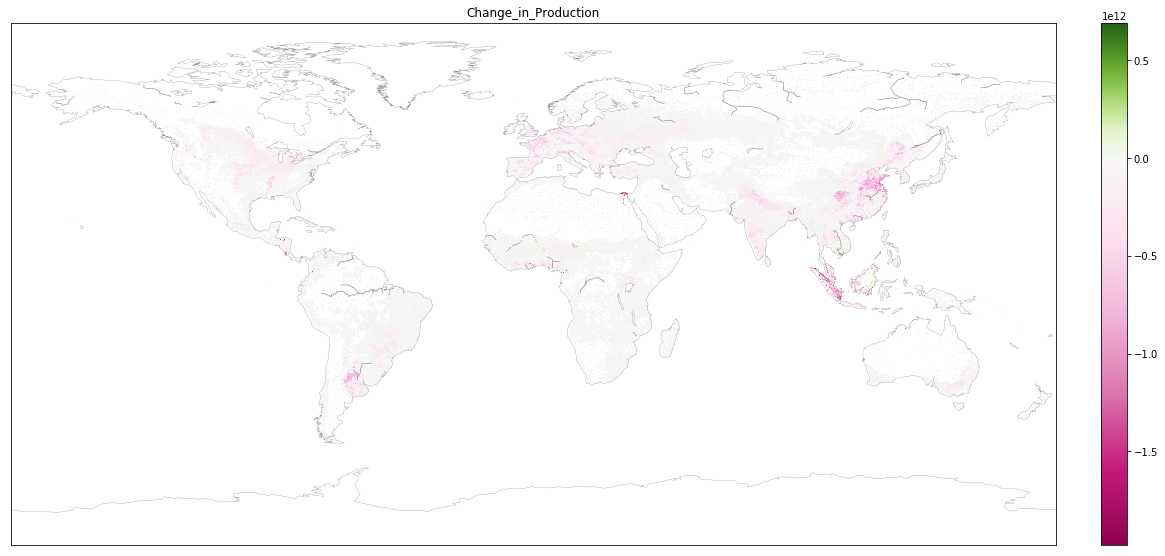

In [50]:
visualize_data(expo,'Change_in_Production',colorscheme = 'diverging')

# Visualization functions

In [44]:
## Geographical visualization function
def visualize_data(df,col_name,savefig=False,colorscheme='diverging',
                   shape=(2160,4320),title=None,resize=False):

    
    fig,axes = plt.subplots(1, 1, figsize=(20,15))

    # -- Prepare data --
    #Make a zeros_df of length 9331200
    match_af = hb.ArrayFrame(match_raster)
    zeros_array = np.zeros(match_af.size)
    zeros_df = pd.DataFrame(zeros_array)
    DF = df[col_name].reset_index()
    ### Merge with zeros_df to include non-ag pixels
    full_df = pd.merge(zeros_df, DF, left_index=True, right_on='pixel_id', how='outer')
    
    ## -- Plot column --
    
    #Colorscale
    if colorscheme == 'diverging':
        raw_cmap =  plt.get_cmap('PiYG')
        cmap = customColorMap(raw_cmap, full_df[col_name],resize)
    elif colorscheme == 'sequential':
        raw_cmap = plt.get_cmap('inferno_r') #alternatively 'magma'
        cmap = customColorMap(raw_cmap, full_df[col_name],resize)
    #else:
        #cmap = replicateColorMap(colorscheme,vmin=14.022869333967861,vmax=19.24083736317894)
        
    
    
    
    #Plot data
    data = np.array(full_df[col_name])
    bm = Basemap()
    im = bm.imshow(np.flipud(data.reshape(shape)),cmap=cmap)
    bm.drawcoastlines(linewidth=0.15, color='0.1')
    
    cbar = plt.colorbar(im, orientation='vertical',fraction=0.0234, pad=0.04)
    
    if title == None:
        plt.title(col_name)
    else:
        plt.title(title)
    plt.show()
  
    if savefig != False:
        fig.savefig(savefig)
        
   #if colorscheme != cmap:    
   #     return cmap

def customColorMap(cmap, serie, resize=False, name='blabla'):
    '''Charlie's function to re-center and re-size colormap'''
    
    vmax = serie.max()
    vmin = serie.min()
    midpoint= 1 - vmax / (vmax + abs(vmin))
    #print(vmin,vmax,midpoint)
    
    
    if resize!=False: 
        start=resize[0]
        stop =resize[1]
        ### Could do directly with quantiles e.g  start = 1 / (serie.quantile(0.1) / serie.min() )
        ### And stop =  1 / (serie.quantile(0.9) / serie.max() )
    else:
        start = 0
        stop  = 1
    
    cdict = {
        'red': [],
        'green': [],
        'blue': [],
        'alpha': []
    }

    # regular index to compute the colors
    reg_index = np.linspace(start, stop, 257)

    # shifted index to match the data
    shift_index = np.hstack([
        np.linspace(0.0, midpoint, 128, endpoint=False), 
        np.linspace(midpoint, 1.0, 129, endpoint=True)
    ])

    for ri, si in zip(reg_index, shift_index):
        r, g, b, a = cmap(ri)

        cdict['red'].append((si, r, r))
        cdict['green'].append((si, g, g))
        cdict['blue'].append((si, b, b))
        cdict['alpha'].append((si, a, a))

    newcmap = matplotlib.colors.LinearSegmentedColormap(name, cdict)
    plt.register_cmap(cmap=newcmap)

    return newcmap

In [ ]:
# Visualize input raster ??

def plot_col(df, col_name, shape=(2160, 4320)):
    m = np.array(df[col_name])
    bm = Basemap()
    im = bm.imshow(np.flipud(m.reshape(shape)))
    bm.drawcoastlines(linewidth=0.15, color='0.1')
    cbar = plt.colorbar(im, orientation='horizontal')
    plt.title(col_name)
    plt.show()

# Various: nc files, reclassify

In [ ]:
# To extract NC files, use this HB funciton:
hb.extract_luh_netcdf_to_geotiffs(states_path, output_dir, year - 2015)  # 0 = 2015, last year is 85=2100

In [ ]:
# Here's the recategorization i used,  notated as [ESA class] = [SEALS output class, 'esa description', 'seals description']:

p.esacci_to_seals_simplified_correspondence = OrderedDict()
p.esacci_to_seals_simplified_correspondence[0] = [0, 'ndv', 'ndv']
p.esacci_to_seals_simplified_correspondence[10] = [2, 'crop_rainfed', 'crop']
p.esacci_to_seals_simplified_correspondence[11] = [2, 'crop_rainfed_herb', 'crop']
p.esacci_to_seals_simplified_correspondence[12] = [2, 'crop_rainfed_tree', 'crop']
p.esacci_to_seals_simplified_correspondence[20] = [2, 'crop_irrigated', 'crop']
p.esacci_to_seals_simplified_correspondence[30] = [2, 'crop_natural_mosaic', 'crop']
p.esacci_to_seals_simplified_correspondence[40] = [2, 'natural_crop_mosaic', 'crop']
p.esacci_to_seals_simplified_correspondence[50] = [4, 'tree_broadleaved_evergreen', 'forest']
p.esacci_to_seals_simplified_correspondence[60] = [4, 'tree_broadleaved_deciduous_closed_to_open_15', 'forest']
p.esacci_to_seals_simplified_correspondence[61] = [4, 'tree_broadleaved_deciduous_closed_40', 'forest']
p.esacci_to_seals_simplified_correspondence[62] = [4, 'tree_broadleaved_deciduous_open_15_40', 'forest']
p.esacci_to_seals_simplified_correspondence[70] = [4, 'tree_needleleaved_deciduous_closed_to_open_15', 'forest']
p.esacci_to_seals_simplified_correspondence[71] = [4, 'tree_needleleaved_evergreen_closed_to_open_15_extended', 'forest']
p.esacci_to_seals_simplified_correspondence[72] = [4, 'tree_needleleaved_evergreen_open_15_40', 'forest']
p.esacci_to_seals_simplified_correspondence[80] = [4, 'tree_needleleaved_deciduous_closed_to_open_15', 'forest']
p.esacci_to_seals_simplified_correspondence[81] = [4, 'tree_needleleaved_deciduous_closed_40', 'forest']
p.esacci_to_seals_simplified_correspondence[82] = [4, 'tree_needleleaved_deciduous_open_15_40', 'forest']
p.esacci_to_seals_simplified_correspondence[90] = [4, 'tree_mixed_type', 'forest']
p.esacci_to_seals_simplified_correspondence[100] = [4, 'mosaic_tree_and_shrub_50_herbaceous_cover_50', 'forest']
p.esacci_to_seals_simplified_correspondence[110] = [5, 'mosaic_herbaceous_cover_50_tree_and_shrub_50', 'shrubland']
p.esacci_to_seals_simplified_correspondence[120] = [5, 'shrubland', 'shrubland']
p.esacci_to_seals_simplified_correspondence[121] = [5, 'evergreen_shrubland', 'shrubland']
p.esacci_to_seals_simplified_correspondence[122] = [5, 'deciduous_shrubland_', 'shrubland']
p.esacci_to_seals_simplified_correspondence[130] = [3, 'grassland', 'grassland']
p.esacci_to_seals_simplified_correspondence[140] = [5, 'lichens_and_mosses', 'shrubland']
p.esacci_to_seals_simplified_correspondence[150] = [5, 'sparse_vegetation_tree_shrub_herbaceous_cover_15', 'shrubland']
p.esacci_to_seals_simplified_correspondence[151] = [4, 'sparse_tree_15', 'forest']
p.esacci_to_seals_simplified_correspondence[152] = [5, 'sparse_shrub_15', 'shrubland']
p.esacci_to_seals_simplified_correspondence[153] = [5, 'sparse_herbaceous_cover_15', 'shrubland']
p.esacci_to_seals_simplified_correspondence[160] = [4, 'tree_cover_flooded_fresh_or_brakish_water', 'forest']
p.esacci_to_seals_simplified_correspondence[170] = [4, 'tree_cover_flooded_saline_water', 'forest']
p.esacci_to_seals_simplified_correspondence[180] = [5, 'shrub_or_herbaceous_cover_flooded_fresh_saline_brakish_water', 'shrubland']
p.esacci_to_seals_simplified_correspondence[190] = [1, 'urban_areas', 'urban']
p.esacci_to_seals_simplified_correspondence[200] = [7, 'bare_areas', 'other']
p.esacci_to_seals_simplified_correspondence[201] = [7, 'consolidated_bare_areas', 'other']
p.esacci_to_seals_simplified_correspondence[202] = [7, 'unconsolidated_bare_areas', 'other']
p.esacci_to_seals_simplified_correspondence[210] = [6, 'water_bodies', 'water']
p.esacci_to_seals_simplified_correspondence[220] = [7, 'permanent_snow_and_ice', 'other']